## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.WishartParams import WishartParam
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt
import DP_lrvb as lrvb
import DP_functional_perturbation_lib as dp_fun_pert

from copy import deepcopy

from scipy import optimize, integrate

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(8967869)
# np.random.seed(54325)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 2 # true number of clusters

true_info_x = 0.1 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(true_info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 2.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_wishart_dof = x_dim
prior_wishart_scale = true_info_x / prior_wishart_dof
kappa = 0.001

# variational truncation 
k_approx = 10


observed mixture proportions: 
 [ 0.486  0.514]
true mixture proportions: 
 [ 0.5  0.5]


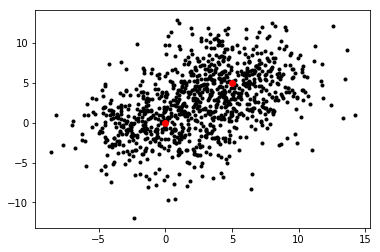

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

# Set up VB model

In [4]:
# global parameters
global_params = ModelParamsDict('global')

# variational MVN parameters
global_params.push_param(
    PosDefMatrixParamVector(name='info_mu', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means

# variational beta parameters
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation

# variational wishart parameters
global_params.push_param(
    WishartParam(name = 'wishart', size = x_dim))


In [5]:
# local indicators
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)

In [6]:
# prior paramters
prior_params = ModelParamsDict('prior_params')

# prior mean
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))

# prior wishart parameters
prior_params.push_param(WishartParam(name = 'prior wishart', size = x_dim))
prior_params['prior wishart'].params['v'].set(prior_wishart_scale)
prior_params['prior wishart'].params['df'].set(prior_wishart_dof)


prior_params.push_param(ScalarParam(name='kappa', val = kappa))

# dp paramter
prior_params.push_param(ScalarParam(name='alpha', val=alpha))


# Initialize

In [7]:
## initialize VB params

vb_params.set_free(np.random.random(vb_params.free_size()))

#vb_params['global']['inv_wishart_scale'].set(np.linalg.inv(true_info_x / x_dim))
#vb_params['global']['wishart_dof'].set(np.array([x_dim]))

# vb_params['global']['mu'].set(true_mu)

init_free_params = vb_params.get_free()
global_init_free_params = vb_params['global'].get_free()

model = dp.DPNormalMixture(x, vb_params, prior_params)

# Run CAVI 

CAVI terminated successfully :)
iterations ran:  639
elbo:  3671.80542424


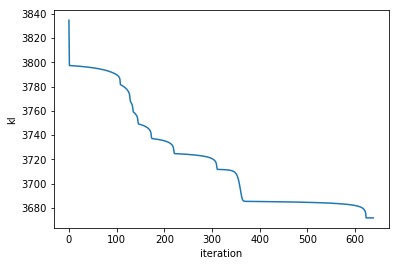

In [8]:
dp_opt.run_cavi(model, init_free_params, max_iter = 1000, tol = 1e-6, disp = False)
cavi_results = deepcopy(model)
print('elbo: ', cavi_results.get_kl())


### examine results of CAVI

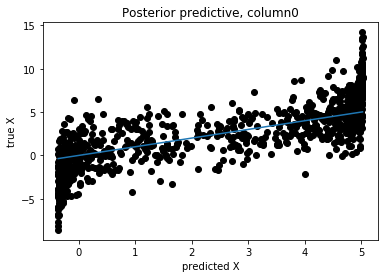

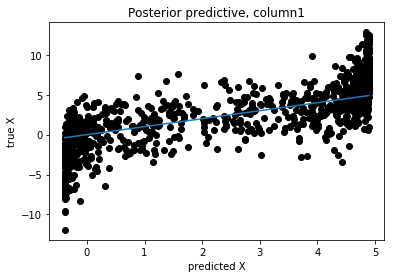

In [9]:
# plot posterior predictive
e_z = cavi_results.vb_params['local']['e_z'].get()
mu = cavi_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [10]:
# lets look at the estimated mixture proportions

tau = cavi_results.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi, '\n')

heavy_clusters = post_pi > 1 / k_approx # clusters with significant weights 

print('true number of clusters: ', k_true)
print('number of "posterior clusters" (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)

true_proportions [ 0.5  0.5]
estimated proportions:  [  4.67018661e-01   5.30991044e-01   6.63431616e-04   4.42287744e-04
   2.94858496e-04   1.96572331e-04   1.31048220e-04   8.73654803e-05
   5.82436535e-05   1.16487307e-04] 

true number of clusters:  2
number of "posterior clusters" (ie. no. clusters w/ siginifcant weights):  2
recall variational truncation:  10


In [11]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
post_mean = cavi_results.vb_params['global']['mu'].get()[heavy_clusters, :]
print(post_mean)

true means: 
[[0 0]
 [5 5]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[-0.37012196 -0.38746702]
 [ 5.02292882  4.89249889]]


here, black are data points. red are the true means. blue are the posterior means


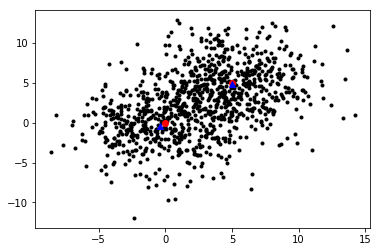

In [12]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')

print('here, black are data points. red are the true means. blue are the posterior means')

# Newton Optimization

In [13]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [14]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-6, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hessp=kl_obj.fun_free_hvp,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done :o')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
newton_tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton

Optimization terminated successfully.
         Current function value: 3671.802061
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 0
done :o


In [15]:
model.vb_params['global'].set_free(newton_tr_opt.x)
model.set_optimal_z()

newton_results = deepcopy(model)

In [16]:
# checking the optima

print('minimizing function value', newton_results.get_kl())

# check that the gradient is close to 0
kl_grad = kl_obj.fun_free_grad(newton_tr_opt.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj.fun_free_hessian(newton_tr_opt.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian eigenvalues all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

minimizing function value 3671.80206085
L_inf norm of gradient:  1.72841442017e-07
time to compute Hessian (sec):  11.091921329498291
Hessian eigenvalues all positive:  True
distance (l2) to minimizer of quadratic approx. :  1.41782887405e-07


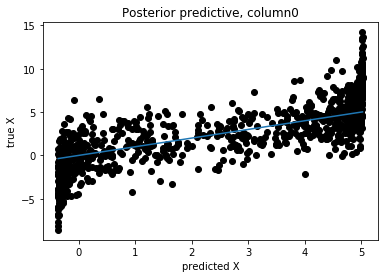

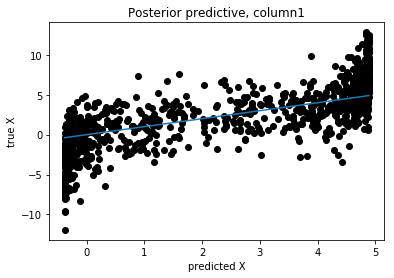

In [17]:
# plot posterior predictive
e_z = newton_results.vb_params['local']['e_z'].get()
mu = newton_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [18]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(newton_results.vb_params['global']['mu'].get())

print('l1 difference (normalized) between means: ', \
      np.mean(np.abs(cavi_results.vb_params['global']['mu'].get() \
                     - newton_results.vb_params['global']['mu'].get())))

[[-0.37012196 -0.38746702]
 [ 5.02292882  4.89249889]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]]
[[-0.36751795 -0.38486111]
 [ 5.02063069  4.89019936]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]
 [ 2.5021102   2.42453838]]
l1 difference (normalized) between means:  0.000490378656723


In [19]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_vector() - newton_results.vb_params.get_vector())))

l1 difference (normalized) between all params:  0.000209410918544


# Functional sensitivity analysis

In particular, we are interested in how posterior quantities depend on our choice of prior on the v-sticks. Recall that in the DP, each stick is drawn from a $\text{Beta}(1, \alpha)$ distribution. 

In [21]:
# define the function that extracts your desired posterior moments. 
# here, we are interested in the mean posterior stick lengths
def get_v_sticks(model, global_free_params, k_post): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    return model.vb_params['global']['v_sticks'].e()[k_post, 0]

# set up lrvb class
# the hessian is computed in the __init__ so we can use it later too; its only computed once
alpha_sensitivity = lrvb.DPAlphaSensitivity(model, newton_tr_opt.x)

evaluating hessian ...
ok


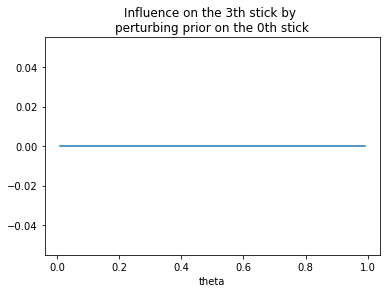

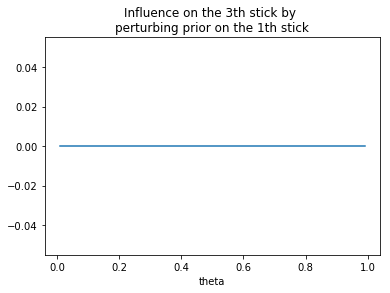

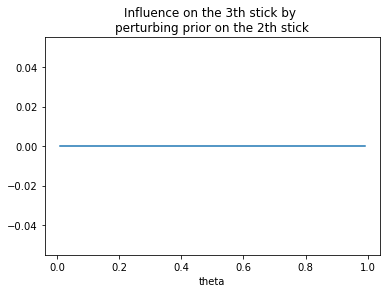

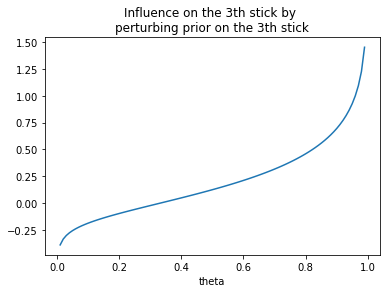

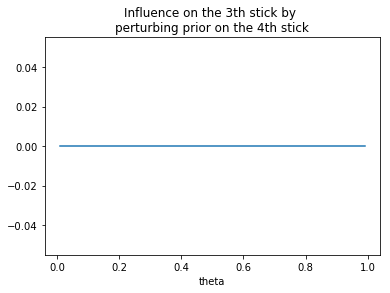

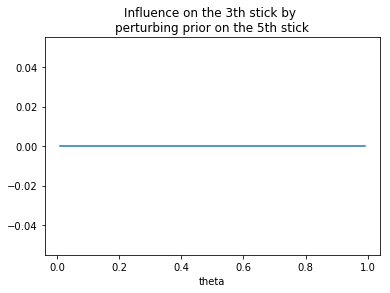

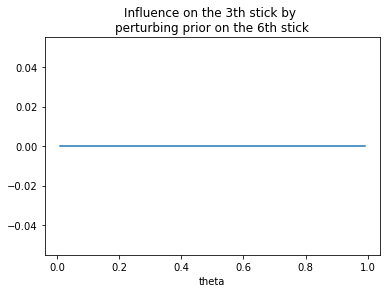

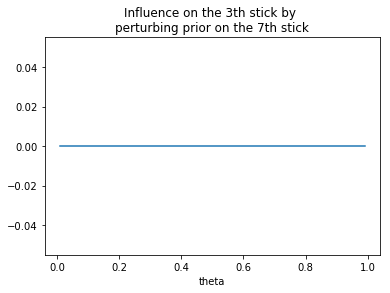

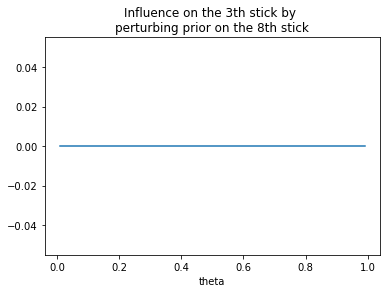

In [22]:
k_post = 3 # specify which posterior stick length you want to examine

theta = np.linspace(0.01, 0.99, 100)
ifun_v_sticks = np.zeros((k_approx - 1, len(theta)))

for k_prior in range(k_approx - 1): 
    ifun_v_sticks[k_prior, :] = \
            alpha_sensitivity.influence_function(theta, k_prior, lambda x : get_v_sticks(model, x, k_post))
    
    plt.figure()
    plt.plot(theta, ifun_v_sticks[k_prior, :])
    plt.xlabel('theta')
    title = "Influence on the {}th stick by \nperturbing prior on the {}th stick".format(k_post, k_prior)
    plt.title(title)

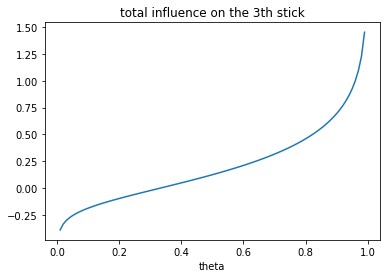

In [23]:
plt.figure()
plt.plot(theta, np.sum(ifun_v_sticks, axis = 0))
plt.xlabel('theta')
plt.title('total influence on the {}th stick'.format(k_post))

#### let us compute the predicted sensitivity to a given perturbation $u(\theta)$

In [24]:
# define your pertubation: 
def u(theta): 
    return 1.0 * ((theta > 0.0) & (theta < 1.0))

# wrap the influence function
def Influence(theta): 
    I = 0.0
    for k in range(k_approx - 1): 
        I += alpha_sensitivity.influence_function(theta, k, lambda x : get_v_sticks(model, x, k_post))
        
    return I


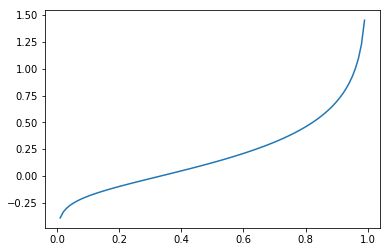

In [25]:
plt.plot(theta, Influence(theta))

In [44]:
epsilon = 0.01

model_u_pert = dp_fun_pert.PerturbedKL(x, vb_params, prior_params, lambda theta : epsilon * u(theta))
kl_pert_obj = Objective(model_u_pert.vb_params['global'], model_u_pert.pertubed_kl)

In [45]:
u_pert_opt = minimize_kl(kl_pert_obj, newton_tr_opt.x) # run newton

Optimization terminated successfully.
         Current function value: -13954.541509
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0
done :o


In [46]:
model_u_pert.vb_params['global'].set_free(u_pert_opt.x)
model_u_pert.set_optimal_z()

In [43]:
# true senstivity
perturbed_mean = model_u_pert.vb_params['global']['v_sticks'].e()[:,0]
old_mean = newton_results.vb_params['global']['v_sticks'].e()[:,0]

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

true sensitivity: 
 [  4.77718027e-05   6.00905959e-04   5.82943274e-04   4.64920329e-05
   4.67091158e-05   1.49921230e-03   2.31595926e-03   8.39006220e-05
   8.44007694e-05]


In [39]:
t0 = time.time()
u_sensitivity = integrate.quad(lambda theta : u(theta) * Influence(theta)[2, :], 0.0, 1.0)
t_integral = time.time() - t0

print(u_sensitivity)
# print(t_integral)

(0.0009971103563245348, 1.2563250456664246e-08)


In [67]:
t0 = time.time()
u_sensitivity = integrate.quad(lambda theta : u(theta) * I(theta)[0, :], 0.0, 1.0)
t_integral = time.time() - t0

print(u_sensitivity)
# print(t_integral)

(4.999300549998094e-07, 5.550162685057747e-09)


In [68]:
t0 = time.time()
u_sensitivity = integrate.quad(lambda theta : u(theta) * I(theta)[1, :], 0.0, 1.0)
t_integral = time.time() - t0

print(u_sensitivity)
# print(t_integral)

(0.0011557331068963064, 2.0803464823200557e-09)


### we can look on the influence function on posterior co-clustering

In [ ]:
# function that extracts desired posterior quantity
def get_co_clustering(model, global_free_params, n1, n2): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    e_z1 = model.vb_params['local']['e_z'].get()[n1, :]
    e_z2 = model.vb_params['local']['e_z'].get()[n2, :]
    
    return np.dot(e_z1, e_z2)

In [ ]:
# pick two data points and visualize

# the indices of the data points. 
n1 = 0
n2 = 1

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. yellow are the chosen data points. ')

In [ ]:
theta = np.linspace(0.01, 0.99, 100)
ifun_co_clustering = np.zeros((k_approx - 1, len(theta)))

for k_prior in range(k_approx - 1): 
    ifun_co_clustering[k_prior, :] = alpha_sensitivity.influence_function(theta, k_prior, \
                                        lambda x: get_co_clustering(model, x, n1, n2))
    
    plt.figure()
    plt.plot(theta, ifun_v_sticks[k_prior, :])
    plt.xlabel('theta')
    title = "Influence on the co-clustering by \nperturbing prior on the {}th stick".format(k_prior)
    plt.title(title)

In [ ]:
plt.figure()
plt.plot(theta, np.sum(ifun_co_clustering, axis = 0))
plt.xlabel('theta')
plt.title('total influence on the co-clustering'.format(k_post))